In [16]:
# Cell 1 — Setup imports and PYTHONPATH
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

# assume this notebook lives in project/notebooks/
PROJECT_ROOT = Path.cwd().parent
SRC_PATH     = PROJECT_ROOT / 'src'
sys.path.insert(0, str(SRC_PATH))

from utils  import load_image, load_mask, compute_vector_field
from engine import AntEnv
from model  import AntModel


In [17]:
# Cell 2 — Helper to pack one observation into tensors
def pack_inputs(patch_np, memory, device):
    pt = (
        torch.from_numpy(patch_np.astype(np.float32)/255)
             .permute(2,0,1)
             .unsqueeze(0)
             .to(device)
    )
    mem_t = []
    for p_np, a_np in memory:
        p_t = (
            torch.from_numpy(p_np.astype(np.float32)/255)
                 .permute(2,0,1)
                 .to(device)
        )
        a_t = torch.from_numpy(a_np.astype(np.float32)).to(device)
        mem_t.append((p_t, a_t))
    return pt, mem_t


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

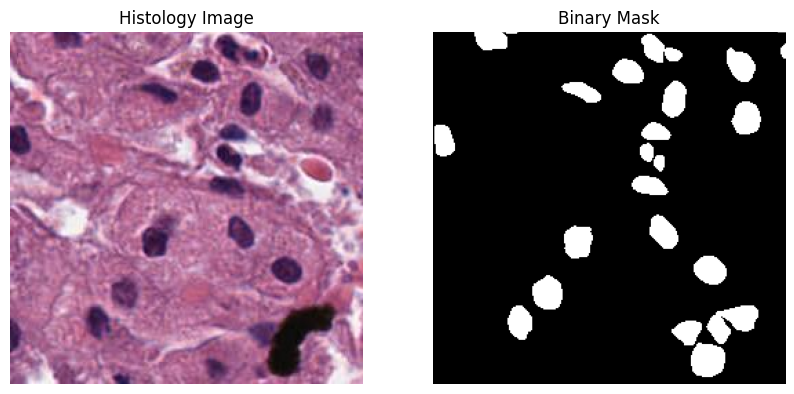

In [26]:
# Cell 3 — Load a single image+mask pair
# Adjust the index or filename as needed:
img_path  = PROJECT_ROOT / 'data' / 'Fold1_jpg' / 'images' / '2245.jpg'
mask_path = PROJECT_ROOT / 'data' / 'Fold1_jpg' / 'masks'  / '2245.jpg'

img  = load_image(str(img_path))
mask = load_mask(str(mask_path))
vf   = compute_vector_field(mask)

# Display to verify
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Histology Image')
plt.imshow(img); plt.axis('off')

plt.subplot(1,2,2)
plt.title('Binary Mask')
plt.imshow(mask, cmap='gray'); plt.axis('off')


In [27]:
# Cell 4 — Instantiate and load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make sure n_actions matches how you trained (e.g. 8)
model = AntModel(
    in_channels=3,
    patch_size=(16,16),
    emb_dim=128,
    n_actions=8,
    n_heads=4
).to(device)

# Path to your saved checkpoint:
ckpt = PROJECT_ROOT / 'Notebooks' / 'agent_0_step10720.pth'
model.load_state_dict(torch.load(ckpt, map_location=device))
model.eval()
print("Loaded model from", ckpt)


Loaded model from /Users/jeremiasz/Desktop/AntNet/Notebooks/agent_0_step10720.pth


In [28]:
# Cell 4 — Instantiate and load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make sure n_actions matches how you trained (e.g. 8)
model = AntModel(
    in_channels=3,
    patch_size=(16,16),
    emb_dim=128,
    n_actions=8,
    n_heads=4
).to(device)

# Path to your saved checkpoint:
model.load_state_dict(torch.load(ckpt, map_location=device))
model.eval()
print("Loaded model from", ckpt)


Loaded model from /Users/jeremiasz/Desktop/AntNet/Notebooks/agent_0_step10720.pth


In [29]:
# Cell 5 — Run 50 greedy rollouts from random positions

NUM_AGENTS = 50
T = 500

trajectories = []

for i in range(NUM_AGENTS):
    # fresh env for each agent (random start inside reset)
    env = AntEnv(
        img, mask, vf,
        kernel_size=(16,16),
        memory_len=10,
        max_steps=T,
        boundary='torus'
    )
    obs_patch, mem = env.reset()

    # greedy rollout
    for _ in range(T):
        pt, mem_t = pack_inputs(obs_patch, mem, device)
        with torch.no_grad():
            logits = model(pt, mem_t)
        action = int(logits.argmax(dim=-1).item())
        (obs_patch, mem), _, done, _ = env.step(action)
        if done:
            break

    # store this agent's trajectory
    trajectories.append(env.trajectory)
    print(f'agent {i}')


agent 0
agent 1
agent 2
agent 3
agent 4
agent 5
agent 6
agent 7
agent 8
agent 9
agent 10
agent 11
agent 12
agent 13
agent 14
agent 15
agent 16
agent 17
agent 18
agent 19
agent 20
agent 21
agent 22
agent 23
agent 24
agent 25
agent 26
agent 27
agent 28
agent 29
agent 30
agent 31
agent 32
agent 33
agent 34
agent 35
agent 36
agent 37
agent 38
agent 39
agent 40
agent 41
agent 42
agent 43
agent 44
agent 45
agent 46
agent 47
agent 48
agent 49


In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

os.makedirs('frames', exist_ok=True)
frames = []

for t in range(0, T+1, 5):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(img,  alpha=1.0)
    inv_mask = 1 - mask
    ax.imshow(inv_mask, cmap='gray', alpha=0.2)
    ax.axis('off')
    ax.set_title(f'Step {t}/{T}')

    for traj in trajectories:
        # get up to step t, then take only the last 10 (or fewer)
        pts = np.array(traj[:t])
        last10 = pts[-20:]
        if len(last10)==0:
            continue

        # scatter with alpha gradient 0.2→1.0
        for i, (x, y) in enumerate(last10):
            α = 0.2 + 0.8 * (i / (len(last10)-1))
            ax.scatter(x, y, s=20, color='blue', alpha=α)

    # grab an RGB frame from the agg canvas
    fig.canvas.draw()
    h, w = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    buf = buf.reshape(h, w, 4)[:, :, :3]   # drop alpha
    frames.append(buf)
    plt.close(fig)
    print(f'frame: {t}')

# write out the GIF
gif_path = 'ant_scatter_fade_10720.gif'
imageio.mimsave(gif_path, frames, fps=5)
print(f'Wrote animation to {gif_path}')


frame: 0
frame: 5
frame: 10
frame: 15
frame: 20
frame: 25
frame: 30
frame: 35
frame: 40
frame: 45
frame: 50
frame: 55
frame: 60
frame: 65
frame: 70
frame: 75
frame: 80
frame: 85
frame: 90
frame: 95
frame: 100
frame: 105
frame: 110
frame: 115
frame: 120
frame: 125
frame: 130
frame: 135
frame: 140
frame: 145
frame: 150
frame: 155
frame: 160
frame: 165
frame: 170
frame: 175
frame: 180
frame: 185
frame: 190
frame: 195
frame: 200
frame: 205
frame: 210
frame: 215
frame: 220
frame: 225
frame: 230
frame: 235
frame: 240
frame: 245
frame: 250
frame: 255
frame: 260
frame: 265
frame: 270
frame: 275
frame: 280
frame: 285
frame: 290
frame: 295
frame: 300
frame: 305
frame: 310
frame: 315
frame: 320
frame: 325
frame: 330
frame: 335
frame: 340
frame: 345
frame: 350
frame: 355
frame: 360
frame: 365
frame: 370
frame: 375
frame: 380
frame: 385
frame: 390
frame: 395
frame: 400
frame: 405
frame: 410
frame: 415
frame: 420
frame: 425
frame: 430
frame: 435
frame: 440
frame: 445
frame: 450
frame: 455
frame: 460